169009152/169001437 [==============================] - 13s 0us/step
Epoch 1/100
1250/1250 [==============================] - 30s 24ms/step - loss: 4.0976 - accuracy: 0.0596 - precision: 0.4113 - recall: 0.0013 - val_loss: 3.7203 - val_accuracy: 0.1082 - val_precision: 0.5038 - val_recall: 0.0132
Epoch 2/100
1250/1250 [==============================] - 30s 24ms/step - loss: 3.4945 - accuracy: 0.1565 - precision: 0.5836 - recall: 0.0209 - val_loss: 3.3012 - val_accuracy: 0.1926 - val_precision: 0.6055 - val_recall: 0.0376
Epoch 3/100
1250/1250 [==============================] - 29s 24ms/step - loss: 3.1069 - accuracy: 0.2281 - precision: 0.6556 - recall: 0.0583 - val_loss: 3.0840 - val_accuracy: 0.2330 - val_precision: 0.6600 - val_recall: 0.0658
Epoch 4/100
1250/1250 [==============================] - 29s 23ms/step - loss: 2.7968 - accuracy: 0.2880 - precision: 0.6807 - recall: 0.1046 - val_loss: 2.9539 - val_accuracy: 0.2699 - val_precision: 0.6591 - val_recall: 0.0988
Epoch 5/100
1250

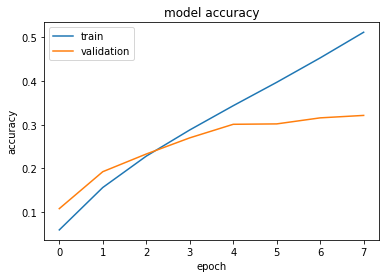

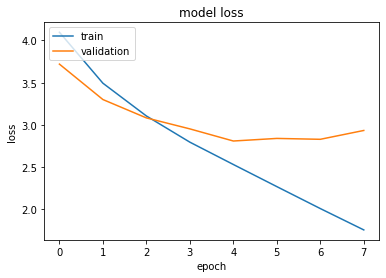

In [2]:
import tensorflow 
import tensorflow.keras
from keras.datasets import cifar100
import numpy as np
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
from keras.activations import relu
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.metrics import Precision,Recall
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from datetime import datetime
import tensorboard
import keras

(x_train,y_train),(x_test,y_test)=cifar100.load_data()


es= EarlyStopping(monitor='val_loss', patience=3)
mc= ModelCheckpoint(filepath='ResNet18_ADAM_NoRegularization.h5', monitor='val_loss', save_best_only=True)

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

mean = x_train.mean()
std= x_train.std()
x_train=(x_train-mean)/std

mean = x_test.mean()
std= x_test.std()
x_test=(x_test-mean)/std


def residual_layer( x, filters): 
  
  
  conv= Conv2D(filters, (3, 3), padding='same')(x)
  r=Activation(relu)(conv)
  conv1=Conv2D(filters, (3, 3), padding='same')(r) 

  return keras.layers.add([conv1,x])

def next_stage_layer(x, filters): 
  
  conv= Conv2D(filters, (3, 3),strides=2, padding='same')(x)
  r=Activation(relu)(conv)
  conv1=Conv2D(filters, (3, 3), padding='same')(r) 

  conv2= Conv2D(filters, (1, 1), padding='same',strides=(2,2))(x)

  return keras.layers.add([conv1,conv2])

def resnet(input_shape):
  inputs = Input(shape=input_shape)
  
  
  conv_1 = Conv2D(64, (7, 7), padding='same',strides=1, input_shape=(32,32,3))(inputs)
  max_pool1= MaxPooling2D((3,3),padding='same',strides=2)(conv_1)
  relu_1 = Activation(relu)(max_pool1)
 
  res_1=residual_layer(relu_1,64)
  relu_2= Activation(relu)(res_1)

  res_2=residual_layer(relu_2,64)
  relu_3= Activation(relu)(res_2)

  res_3= next_stage_layer(relu_3,128)
  relu_4= Activation(relu)(res_3)

  res_4=residual_layer(relu_4,128)
  relu_5= Activation(relu)(res_4)

  res_5= next_stage_layer(relu_5,256)
  relu_6= Activation(relu)(res_5)

  res_6=residual_layer(relu_6,256)
  relu_7= Activation(relu)(res_6)

  res_7=residual_layer(relu_7,256)
  relu_8= Activation(relu)(res_7)
  
  res_8=residual_layer(relu_8,256)
  relu_9= Activation(relu)(res_8)

  avg_pool=  x = AveragePooling2D(pool_size=4)(relu_9)
  flat= Flatten()(avg_pool)
  dense1= Dense(1000,activation='relu')(flat)
  dense2= Dense(100,activation='softmax')(dense1)

  model = Model(inputs=inputs, outputs=dense2)
  return model

model = resnet((32,32,3))

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy',Precision(),Recall()])
history=model.fit(x=x_train,y=y_train,epochs=100, validation_split=0.2, shuffle=True, callbacks=[es,mc])

from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [3]:
import keras 

(x_train,y_train),(x_test,y_test)=cifar100.load_data()
y_test=to_categorical(y_test)

mean = x_test.mean()
std= x_test.std()
x_test=(x_test-mean)/std


best_model= keras.models.load_model('ResNet18_ADAM_NoRegularization.h5')
_, acc,precision,recall = best_model.evaluate(x_test, y_test)

print("Accuracy: "+str(acc*100)+"%")
print("Precision: "+str(precision*100)+"%")
print("Recall: "+str(recall*100)+"%")

313/313 [==============================] - 3s 9ms/step - loss: 2.7825 - accuracy: 0.3080 - precision: 0.6703 - recall: 0.1368
Accuracy: 30.799999833106995%
Precision: 67.02596545219421%
Recall: 13.680000603199005%
